<a href="https://colab.research.google.com/github/hardiksahi/MachineLearning/blob/handle_high_cardinality_categorical/1_Target_Encoding_High_Cardinality_Catgorical_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**High cardinality categorical features:** These are the features that have >100 levels/ categories and they are nominal in nature i.e. there is no intrinsic order in them. Examples: Zip code, Unique identofier, City, province etc.

**Why is it important to handle them?**:
A lot of times these features have a lot of predictive power. Usual methods to handle categorical columns e.g. One hot encoding (1 to N encoding) are not sufficient to hanle them. The main reasons are:


*   1 to N encoding creates boolean features corresponding to each distinct category of the feature under consideration. This means that if there are 100 categories for a feature, there will be 100 new boolean features that will be created. This leads to explosion of feature space.
*   These created features are generally very sparse. Hence not very efficient


*   A lot of classical ML methods like tree based methods will have to construct trees very deep to extract any predictive power from these features.

Hence we need to figure out ways to get dense representation of such features that are useful in a wide variety of ML models.




**Ways to handle high cardinality features:**


*   **Weight of Evidence Encoding**: Generally used in finance domain.
*   **Target Encoding**: Introduced in **A Preprocessing Scheme for High-Cardinality Categorical Attributes in Classification and Prediction Problems**: https://dl.acm.org/doi/10.1145/507533.507538

This notebook deals with Target Encoding


**What is Target Encoding?**: It is a type of encoding that replaces each distinct category (in an independent categorical feature) with the statistics derived from the target/output dependent variable. Hence the name.



*   **Binary classification**: Y is binary [0,1]. Target Encoding transforms unique values $X_{i}$ of high cardinality categorical variable X with $S_{i}$ where,  $X_{i}$ -> $S_{i}$ = P(Y=1 | X=$X_{i}$), i is $i^{th}$ unique category.
*   $S_{i}$ = λ($n_{X=X_{i}}$) * $n_{X=X_{i},Y=1}$/$n_{X=X_{i}}$ + (1-λ($n_{X=X_{i}}$))*$n_{Y=1}$/N,
<p>where $n_{X=X_{i},Y=1}$/$n_{X=X_{i}}$ = P(Y=1|X=$X_{i}$) (Conditional probability) and $n_{Y=1}$/N = P(Y=1) (Marginal probability) </p>
* λ($n_{X=X_{i}}$) is a function between 0 and 1 that decides what proportion of conditional probability and marginal probability should be blended to get final pribability $S_{i}$.
* λ($n_{X=X_{i}}$) = 1/(1+$e^{-(n-k)/f}$). For more details  refer to paper.

There are 2 main considerations while performing target encoding:
1. **Overfitting**: Target statistics (mean) is reliable when the sample size is large. e.g. Category A has 100 samples associated with it and Category B has just 5 samples associated with it. In this case, mean calculated for Category A will be more reliable as compared to mean calulated for Category B. As a result, we need to smooth out the mean for Category B. This is generally done by additive smoothing. This means that we blend in the overall mean with the category specific mean so that there is not a lot of dependence on category specific mean. The paper https://dl.acm.org/doi/10.1145/507533.507538 describes a way to handle it. Same is implemented in https://contrib.scikit-learn.org/category_encoders/targetencoder.html. $S_{i}$ above is one possible way of additive smoothing.

2. **Data leakage**: It occurs when while encoding a category of a column in a data point i, we use the target of the same data point while calculating mean (target statistic). This means that we have leaked the information from the target/ output of the datapoint into the encoded value (that will replace the category). This is generally handled by using K Fold CV where we use target statistic calculated from K-1 folds to replace categories in the Kth fold. This ensures that we are not using target/ output of Kth fold for calculating replacement for categories in the Kth fold.

**Note**: Data leakage issues occur in WoE encoding as well. It is handled in exactly the same way as it is handled for Target Encoding.

**Relevant links:**


1.   https://gist.github.com/lmassaron/6695171ff45bae7ef7ddcdad2ad493ca,
2. https://contrib.scikit-learn.org/category_encoders/targetencoder.html
3. https://maxhalford.github.io/blog/target-encoding/: Basic additive smoothing to handle overfitting
4. https://www.kaggle.com/code/ogrellier/python-target-encoding-for-categorical-features/notebook: Implementation of TE as per original paper. DOES NOT HANDLE DATA LEAKAGE
5. https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/target-encoding.html



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, auc

In [5]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
! pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.9 MB/s eta 0:00:00


In [8]:
from category_encoders import TargetEncoder

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! ls /content/drive/MyDrive/ColabNotebooks/Github

In [10]:
## Titanic path: https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/titanic.csv
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Github/titanic.csv")

## Step 1: Define output column

In [11]:
output_column = 'survived'

## Step 2: Split data into train and test set

In [12]:
X = df.copy()
y = df[output_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (1047, 14)
Shape of X_test: (262, 14)


## Step 3: Decide columns to target encode

In [13]:
te_columns = ["home.dest", "cabin", "embarked"]

## Step 4: Use TE to encode columns mentioned in te_columns. TargetEncoder implementation handles overfitting. We will ensure that there is no data leakage by K fold CV


In [14]:
def add_noise(series, noise_level):
  return series * (1 + noise_level * np.random.randn(len(series)))

In [15]:
def perform_target_encoding(train_df, target_col, test_df, columns_to_encode, encode_data_type ='train', handle_data_leakage='k_fold', folds=5, noise_params={'noise_level':0.01}, param_dict={'smoothing':10, 'min_samples_leaf':20}):
  assert train_df is not None and len(train_df)>0, 'Please pass train_data'
  assert target_col is not None, 'Please pass target_col'
  assert target_col in train_df.columns, f'Please ensure that {target_col} is a part of train_df'
  assert all([col in train_df.columns for col in columns_to_encode]), f'Please ensure columns: {columns_to_encode} are present in train_df'
  assert encode_data_type in ['train', 'test'], f'encode_data_type: {encode_data_type} not supported'

  if encode_data_type == 'train':
    ## perform K fold CV to encode training data with TE
    if handle_data_leakage == 'k_fold' and folds>1:
      train_labels_data = train_df[target_col]
      skf = StratifiedKFold(n_splits=folds, random_state=42, shuffle=True)
      encode_train_df_list = []

      for i, (train_index, val_index) in enumerate(skf.split(train_df, train_labels_data)):
        print(f'[START] Encoding fold number: {i}')
        if param_dict is not None:
          #handle_missing='value': Tells encoder to replace NA in column with global mean
          #handle_unknown='value': Tells encoder to replace unknown/ unseen category during fitting with global mean
          enc = TargetEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, **param_dict)
        else:
          ## smoothing: parameter 𝑓 in definition of lambda => How smoothly do we transition between conditional and global mean
          ## min_samples_leaf: parameter k in definition of lambda => Half of number of samples for which we have complete faith in conditional probability.
          enc = TargetEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, smoothing=10, min_samples_leaf=20)

        ## Get data to be encoded with TE (kth fold)
        kth_fold_train_df = train_df.iloc[val_index]
        ## Get remaining k-1 folds that will be used to calculate mean values for categories
        remaining_folds_train_df = train_df.iloc[train_index]
        remaining_folds_labels_data = train_df[target_col].iloc[train_index]

        ## Fit TE on remaining_folds_train_df and remaining_folds_labels_data
        enc.fit(remaining_folds_train_df, remaining_folds_labels_data)

        ## Transform kth_fold_train_df
        kth_fold_encoded_train_df = enc.transform(kth_fold_train_df)

        ## Ensure that raw values/ categories in columns_to_encode are also returned
        print(f'Concatenate raw columns to target encoded df')
        encoded_column_names = [f'{col}_target_encoded' for col in columns_to_encode]
        kth_fold_encoded_train_df = kth_fold_encoded_train_df.rename(columns=dict(zip(columns_to_encode, encoded_column_names)))
        raw_columns_df = kth_fold_train_df[columns_to_encode]
        kth_fold_encoded_train_df = pd.concat([kth_fold_encoded_train_df, raw_columns_df], axis=1)

        ## Add gaussian noise to data
        if noise_params is not None:
          print(f'Adding Gaussian noise to TE columns')
          for col in encoded_column_names:
            kth_fold_encoded_train_df[col] = add_noise(kth_fold_encoded_train_df[col], noise_params['noise_level'])

        encode_train_df_list.append(kth_fold_encoded_train_df)
        print(f'===[END] Encoding fold number: {i}===')

      ## Concatenate encode_train_df_list
      final_encoded_train_df = pd.concat(encode_train_df_list, axis=0)
      return final_encoded_train_df.reindex(train_df.index)

  elif encode_data_type == 'test':
    assert test_df is not None and len(test_df)>0, 'Please pass test_df'
    assert all([col in test_df.columns for col in columns_to_encode]), f'Please ensure columns: {columns_to_encode} are present in test_df'

    print(f'[START] Encoding Test data')
    if param_dict is not None:
      #handle_missing='value': Tells encoder to replace NA in column with global mean
      #handle_unknown='value': Tells encoder to replace unknown/ unseen category during fitting with global mean
      enc = TargetEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, **param_dict)
    else:
      ## smoothing: parameter 𝑓 in definition of lambda => How smoothly do we transition between conditional and global mean
      ## min_samples_leaf: parameter k in definition of lambda => Half of number of samples for which we have complete faith in conditional probability.
      enc = TargetEncoder(cols=columns_to_encode, handle_missing='value', handle_unknown='value', return_df=True, smoothing=10, min_samples_leaf=20)

    ## Fit train_df on enc
    train_label_data = train_df[target_col]
    enc.fit(train_df, train_label_data)

    ## Tranform test_df
    encoded_test_df = enc.transform(test_df)

    ## Update the column names in test_encoded_train_df
    encoded_column_names = [f'{col}_target_encoded' for col in columns_to_encode]
    encoded_test_df = encoded_test_df.rename(columns=dict(zip(columns_to_encode, encoded_column_names)))

    ## Ensure that raw columns are also returned
    print(f'Concatenate raw columns to target encoded df')
    raw_columns_df = test_df[columns_to_encode]
    encoded_test_df = pd.concat([encoded_test_df, raw_columns_df], axis=1)

    ## Add gaussian noise to data
    if noise_params is not None:
      print(f'Adding Gaussian noise to TE columns')
      for col in encoded_column_names:
        encoded_test_df[col] = add_noise(encoded_test_df[col], noise_params['noise_level'])

    print(f'[END] Encoding Test data')

    return encoded_test_df.reindex(test_df.index)


In [16]:
te_X_train_df = perform_target_encoding(X_train, output_column, X_test, te_columns, encode_data_type ='train', handle_data_leakage='k_fold', folds=5, noise_params={'noise_level':0.01}, param_dict={'smoothing':10, 'min_samples_leaf':20})
print(f'Shape of te_X_train_df: {te_X_train_df.shape}')

[START] Encoding fold number: 0
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 0===
[START] Encoding fold number: 1
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 1===
[START] Encoding fold number: 2
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 2===
[START] Encoding fold number: 3
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 3===
[START] Encoding fold number: 4
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 4===
Shape of te_X_train_df: (1047, 17)


In [17]:
te_X_test_df = perform_target_encoding(X_train, output_column, X_test, te_columns, encode_data_type ='test', noise_params={'noise_level':0.01}, param_dict={'smoothing':10, 'min_samples_leaf':20})
print(f'Shape of te_X_test_df: {te_X_test_df.shape}')

[START] Encoding Test data
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
[END] Encoding Test data
Shape of te_X_test_df: (262, 17)


## Step 5: Encode remaining columns using sklearn transformer

In [18]:
te_X_train_df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin_target_encoded', 'embarked_target_encoded', 'boat',
       'body', 'home.dest_target_encoded', 'home.dest', 'cabin', 'embarked'],
      dtype='object')

In [19]:
ordinal_categorical_columns = ['pclass']
one_hot_categorical_column = ["sex"]
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'cabin_target_encoded', 'embarked_target_encoded', 'home.dest_target_encoded']

In [20]:
mixed_preprocessor = ColumnTransformer([("numerical", "passthrough", numerical_columns), ("ordinal_encoding", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_categorical_columns), ("one_hot_encoding", OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False), one_hot_categorical_column)], verbose_feature_names_out=False)
mixed_preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['age', 'sibsp', 'parch', 'fare',
                                  'cabin_target_encoded',
                                  'embarked_target_encoded',
                                  'home.dest_target_encoded']),
                                ('ordinal_encoding',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['pclass']),
                                ('one_hot_encoding',
                                 OneHotEncoder(handle_unknown='ignore',
                                               max_categories=20,
                                               sparse_output=False),
                                 ['sex'])],
                  verbose_feature_names_out=False)

In [ ]:
#mixed_pipe = make_pipeline(mixed_preprocessor, HistGradientBoostingClassifier())

In [21]:
final_encoded_X_train_df = mixed_preprocessor.fit_transform(te_X_train_df)
final_encoded_X_test_df = mixed_preprocessor.transform(te_X_test_df)

## Step 6: Train HistGradientBoostingClassifier

In [22]:
clf = HistGradientBoostingClassifier(verbose=5)

In [ ]:
clf.fit(final_encoded_X_train_df, te_X_train_df[output_column])

In [24]:
precision_te, recall_te, thresholds_te = precision_recall_curve(te_X_test_df[output_column], clf.predict_proba(final_encoded_X_test_df)[:,1])
area_te = auc(recall_te, precision_te)
print(f'area_te: {area_te}')

area_te: 0.8132569421381153


## The above code uses Target Encoding provided by category_encoders package. It uses exact same smoothing as mentioned in original paper

## Step 7: Perform K Fold CV (https://scikit-learn.org/stable/auto_examples/preprocessing/plot_target_encoder.html#sphx-glr-auto-examples-preprocessing-plot-target-encoder-py)

In [25]:
def perform_cv(df, output_column, folds = 5):
  skf = StratifiedKFold(n_splits=folds, random_state=42, shuffle=True)
  recall_list = []
  precision_list = []
  auc_pr_list = []
  for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Start evaluating for fold: {i}")
    ## Perform TE on te_columns
    train_df = df.iloc[train_index]
    target_encoded_train_df = perform_target_encoding(train_df, output_column, None, te_columns, encode_data_type ='train', handle_data_leakage='k_fold', folds=folds, noise_params={'noise_level':0.01}, param_dict={'smoothing':10, 'min_samples_leaf':20})

    ## Perform remaining columns encoding
    mixed_preprocessor = ColumnTransformer([("numerical", "passthrough", numerical_columns), ("ordinal_encoding", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_categorical_columns), ("one_hot_encoding", OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False), one_hot_categorical_column)], verbose_feature_names_out=False)
    mixed_preprocessor.set_output(transform="pandas")
    all_encoded_train_df = mixed_preprocessor.fit_transform(target_encoded_train_df)

    ## Train classifier
    clf = HistGradientBoostingClassifier()
    clf.fit(all_encoded_train_df, train_df[output_column])

    ## Predict on val_df
    val_df = df.loc[val_index]
    target_encoded_val_df = perform_target_encoding(train_df, output_column, val_df, te_columns, encode_data_type ='test', noise_params={'noise_level':0.01}, param_dict={'smoothing':10, 'min_samples_leaf':20})
    all_encoded_val_df = mixed_preprocessor.transform(target_encoded_val_df)

    ## Predict on all_encoded_val_df
    pred_proba = clf.predict_proba(all_encoded_val_df)

    precision, recall, _ = precision_recall_curve(val_df[output_column], pred_proba[:,1])
    precision_list.append(precision)
    recall_list.append(recall)

    pr_auc = auc(recall, precision)
    auc_pr_list.append(pr_auc)
    # print(f'pr_auc: {pr_auc}')

    print(f"End evaluating for fold: {i}")

  return recall_list, precision_list, auc_pr_list


In [26]:
recall_list, precision_list, auc_pr_list = perform_cv(X, output_column, folds = 5)

Start evaluating for fold: 0
[START] Encoding fold number: 0
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 0===
[START] Encoding fold number: 1
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 1===
[START] Encoding fold number: 2
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 2===
[START] Encoding fold number: 3
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 3===
[START] Encoding fold number: 4
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
===[END] Encoding fold number: 4===
[START] Encoding Test data
Concatenate raw columns to target encoded df
Adding Gaussian noise to TE columns
[END] Encoding Test data
End evaluating for fold: 0
Start evaluating for fold: 1
[START] Encoding fold number: 0
Conca

## Plot PR graph for all folds

In [27]:
max_len = max(len(precision) for precision in precision_list)
precisions_arr = np.full((len(precision_list), max_len), np.nan)
recalls_arr = np.full((len(recall_list), max_len), np.nan)
for i in range(len(precision_list)):
    precisions_arr[i, :len(precision_list[i])] = precision_list[i]
    recalls_arr[i, :len(recall_list[i])] = recall_list[i]

mean_precision = np.nanmean(precisions_arr, axis=0)
mean_recall = np.nanmean(recalls_arr, axis=0)
mean_auc_pr = auc(mean_recall, mean_precision)

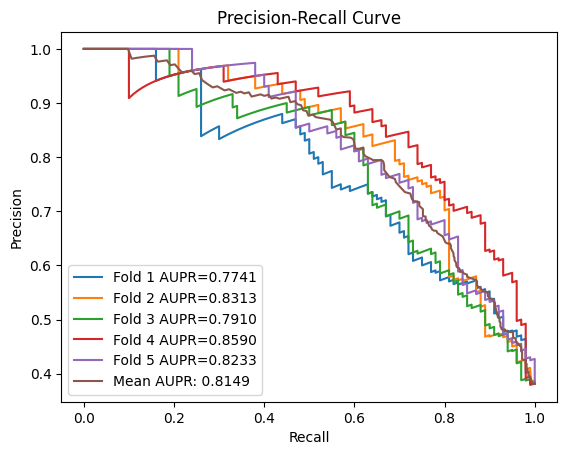

In [28]:
for i in range(len(precision_list)):
    plt.plot(recall_list[i], precision_list[i], label='Fold %d AUPR=%.4f' % (i+1, auc_pr_list[i]))
plt.plot(mean_recall, mean_precision, label='Mean AUPR: {:.4f}'.format(mean_auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()